In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/user/HS400/dd00830/Downloads/Dissertation/Dataset.csv'  
data = pd.read_csv(file_path)

# Preprocessing
data['Label'] = data['Label'].str.lower().str.strip()

# Drop rows with missing text or label
data = data.dropna(subset=['selftext', 'Label'])

# Map labels to integers after normalization
label_map = {label: idx for idx, label in enumerate(data['Label'].unique())}
print(f"Label Mapping: {label_map}")

# Convert labels to numerical codes
labels = data['Label'].map(label_map).tolist()
texts = data['selftext'].tolist()

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)



Label Mapping: {'drug and alcohol': 0, 'early life': 1, 'personality': 2, 'trauma and stress': 3}


In [2]:
from transformers import DistilBertTokenizerFast

# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_texts)).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(8)


In [5]:
from transformers import TFDistilBertForSequenceClassification

# Model Creation
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=len(label_map)
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [6]:
# Train the model and capture the history
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
80/80 [==============================] - 126s 1s/step - loss: 1.1337 - sparse_categorical_accuracy: 0.5219 - val_loss: 0.9236 - val_sparse_categorical_accuracy: 0.6438
Epoch 2/10
80/80 [==============================] - 97s 1s/step - loss: 0.6761 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9038 - val_sparse_categorical_accuracy: 0.6812
Epoch 3/10
80/80 [==============================] - 93s 1s/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8406 - val_loss: 1.0312 - val_sparse_categorical_accuracy: 0.6187
Epoch 4/10
80/80 [==============================] - 93s 1s/step - loss: 0.2792 - sparse_categorical_accuracy: 0.9141 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.6625
Epoch 5/10


In [7]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model
predictions = model.predict(val_dataset)
pred_labels = np.argmax(predictions.logits, axis=-1) 

val_labels_array = np.array(val_labels)

target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]
report = classification_report(val_labels_array, pred_labels, target_names=target_names)

# Print the classification report
print("Classification Report:")
print(report)


20/20 [==============================] - 7s 264ms/step
Classification Report:
                   precision    recall  f1-score   support

 drug and alcohol       0.72      0.78      0.75        37
       early life       0.66      0.86      0.75        43
      personality       0.61      0.71      0.66        35
trauma and stress       0.70      0.36      0.47        45

         accuracy                           0.67       160
        macro avg       0.67      0.68      0.66       160
     weighted avg       0.67      0.67      0.65       160



20/20 [==============================] - 5s 264ms/step


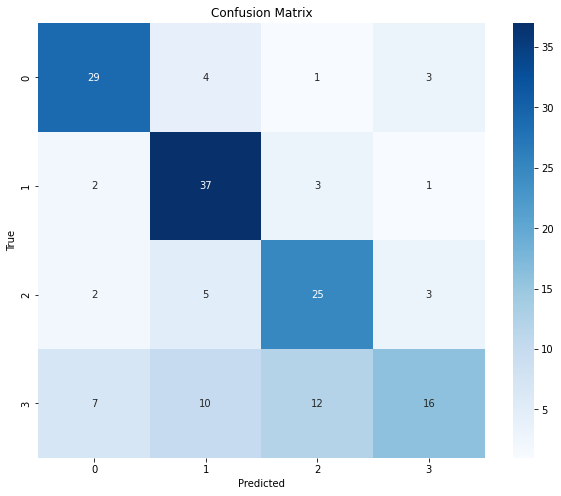

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions from the model
predictions = model.predict(val_dataset)
pred_labels = np.argmax(predictions.logits, axis=-1)

val_labels_array = np.array(val_labels)

# Compute the confusion matrix
cm = confusion_matrix(val_labels_array, pred_labels)

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


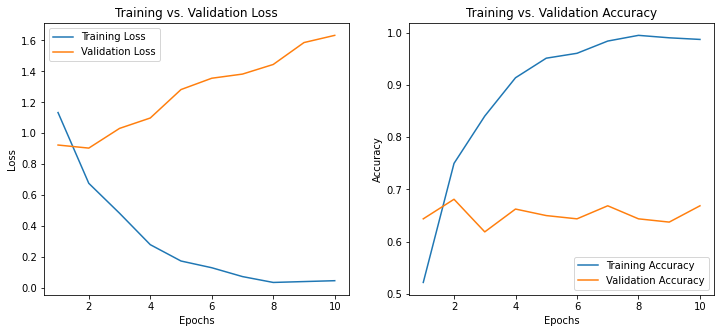

In [9]:
# Extract loss and accuracy from the history object
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Plotting Training vs. Validation Loss
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.show()


## HYPER PARAMETER TUNING:-

In [2]:
import optuna
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

def objective(trial):
    # Define the hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_epochs', 2, 4)
    max_length = trial.suggest_int('max_length', 128, 256)

    # Load the tokenizer and model
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_map))

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        train_labels
    )).shuffle(len(train_texts)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        val_labels
    )).batch(batch_size)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Train the model
    model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

    # Evaluate the model
    eval_loss, eval_accuracy = model.evaluate(val_dataset)

    return eval_loss

2024-09-06 03:19:38.814433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 03:19:40.621227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found
print(f'Best trial: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')


[I 2024-09-06 03:20:36,136] A new study created in memory with name: no-name-797fc20c-8392-49c1-bcbd-1e4a23dce345
/tmp/ipykernel_669797/3419057061.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-09-06 03:20:37.067271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/l

Epoch 1/4
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 155s 7s/step - loss: 1.3852 - sparse_categorical_accuracy: 0.3063 - val_loss: 1.3673 - val_sparse_categorical_accuracy: 0.3938
Epoch 2/4
20/20 [==============================] - 128s 6s/step - loss: 1.3016 - sparse_categorical_accuracy: 0.5031 - val_loss: 1.2275 - val_sparse_categorical_accuracy: 0.5250
Epoch 3/4
20/20 [==============================] - 128s 6s/step - loss: 1.0202 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.9454 - val_sparse_categorical_accuracy: 0.6750
Epoch 4/4
5/5 [==============================] - 10s 2s/step - loss: 0.7621 - sparse_categorical_accuracy: 0.6875


[I 2024-09-06 03:29:51,973] Trial 0 finished with value: 0.7621423602104187 and parameters: {'learning_rate': 1.8959190346356325e-05, 'batch_size': 32, 'num_epochs': 4, 'max_length': 206}. Best is trial 0 with value: 0.7621423602104187.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or 

Epoch 1/3
40/40 [==============================] - 103s 2s/step - loss: 1.3078 - sparse_categorical_accuracy: 0.4031 - val_loss: 1.0725 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/3
40/40 [==============================] - 89s 2s/step - loss: 0.7935 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.8127 - val_sparse_categorical_accuracy: 0.6812
Epoch 3/3
10/10 [==============================] - 6s 591ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.7250


[I 2024-09-06 03:34:39,174] Trial 1 finished with value: 0.8312944173812866 and parameters: {'learning_rate': 3.6055060970196366e-05, 'batch_size': 16, 'num_epochs': 3, 'max_length': 141}. Best is trial 0 with value: 0.7621423602104187.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or 

Epoch 1/2
20/20 [==============================] - 163s 8s/step - loss: 1.3710 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.3273 - val_sparse_categorical_accuracy: 0.5250
Epoch 2/2
5/5 [==============================] - 12s 2s/step - loss: 1.0503 - sparse_categorical_accuracy: 0.6438


[I 2024-09-06 03:40:04,986] Trial 2 finished with value: 1.050301194190979 and parameters: {'learning_rate': 2.1513672633182756e-05, 'batch_size': 32, 'num_epochs': 2, 'max_length': 234}. Best is trial 0 with value: 0.7621423602104187.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or b

Epoch 1/4
80/80 [==============================] - 128s 1s/step - loss: 1.2062 - sparse_categorical_accuracy: 0.4313 - val_loss: 0.9502 - val_sparse_categorical_accuracy: 0.5875
Epoch 2/4
80/80 [==============================] - 114s 1s/step - loss: 0.7656 - sparse_categorical_accuracy: 0.6625 - val_loss: 0.7952 - val_sparse_categorical_accuracy: 0.7063
Epoch 3/4
80/80 [==============================] - 114s 1s/step - loss: 0.5453 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.8609 - val_sparse_categorical_accuracy: 0.6938
Epoch 4/4
20/20 [==============================] - 7s 345ms/step - loss: 0.9639 - sparse_categorical_accuracy: 0.6938


[I 2024-09-06 03:48:03,891] Trial 3 finished with value: 0.9638611078262329 and parameters: {'learning_rate': 3.828158782996343e-05, 'batch_size': 8, 'num_epochs': 4, 'max_length': 164}. Best is trial 0 with value: 0.7621423602104187.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or bu

Epoch 1/3
20/20 [==============================] - 104s 5s/step - loss: 1.3728 - sparse_categorical_accuracy: 0.3156 - val_loss: 1.3297 - val_sparse_categorical_accuracy: 0.4812
Epoch 2/3
20/20 [==============================] - 90s 5s/step - loss: 1.1958 - sparse_categorical_accuracy: 0.5766 - val_loss: 1.0623 - val_sparse_categorical_accuracy: 0.5813
Epoch 3/3
5/5 [==============================] - 6s 1s/step - loss: 0.8281 - sparse_categorical_accuracy: 0.6250


[I 2024-09-06 03:52:56,485] Trial 4 finished with value: 0.8281143307685852 and parameters: {'learning_rate': 2.5529757071740038e-05, 'batch_size': 32, 'num_epochs': 3, 'max_length': 150}. Best is trial 0 with value: 0.7621423602104187.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or 

Epoch 1/2
40/40 [==============================] - 126s 3s/step - loss: 1.2477 - sparse_categorical_accuracy: 0.4563 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.6438
Epoch 2/2
10/10 [==============================] - 8s 767ms/step - loss: 0.7423 - sparse_categorical_accuracy: 0.7250


[I 2024-09-06 03:57:03,650] Trial 5 finished with value: 0.7422806024551392 and parameters: {'learning_rate': 3.590183602004517e-05, 'batch_size': 16, 'num_epochs': 2, 'max_length': 179}. Best is trial 5 with value: 0.7422806024551392.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or b

Epoch 1/4
80/80 [==============================] - 144s 2s/step - loss: 1.1705 - sparse_categorical_accuracy: 0.4703 - val_loss: 0.9332 - val_sparse_categorical_accuracy: 0.6313
Epoch 2/4
80/80 [==============================] - 130s 2s/step - loss: 0.6982 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.7220 - val_sparse_categorical_accuracy: 0.7250
Epoch 3/4
80/80 [==============================] - 130s 2s/step - loss: 0.4715 - sparse_categorical_accuracy: 0.8344 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.7250
Epoch 4/4
20/20 [==============================] - 8s 401ms/step - loss: 0.8340 - sparse_categorical_accuracy: 0.7437


[I 2024-09-06 04:06:06,878] Trial 6 finished with value: 0.8340448141098022 and parameters: {'learning_rate': 3.2673581653949706e-05, 'batch_size': 8, 'num_epochs': 4, 'max_length': 191}. Best is trial 5 with value: 0.7422806024551392.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or b

Epoch 1/3
40/40 [==============================] - 159s 4s/step - loss: 1.3826 - sparse_categorical_accuracy: 0.2844 - val_loss: 1.3589 - val_sparse_categorical_accuracy: 0.4563
Epoch 2/3
40/40 [==============================] - 143s 4s/step - loss: 1.2453 - sparse_categorical_accuracy: 0.5719 - val_loss: 1.1017 - val_sparse_categorical_accuracy: 0.6375
Epoch 3/3
10/10 [==============================] - 10s 1s/step - loss: 0.8567 - sparse_categorical_accuracy: 0.6875


[I 2024-09-06 04:13:43,910] Trial 7 finished with value: 0.8566710352897644 and parameters: {'learning_rate': 1.1263385328134492e-05, 'batch_size': 16, 'num_epochs': 3, 'max_length': 228}. Best is trial 5 with value: 0.7422806024551392.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or 

Epoch 1/4
40/40 [==============================] - 98s 2s/step - loss: 1.3614 - sparse_categorical_accuracy: 0.3703 - val_loss: 1.3073 - val_sparse_categorical_accuracy: 0.4375
Epoch 2/4
40/40 [==============================] - 84s 2s/step - loss: 1.0621 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.6625
Epoch 3/4
40/40 [==============================] - 83s 2s/step - loss: 0.7530 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.6938
Epoch 4/4
10/10 [==============================] - 6s 554ms/step - loss: 0.9064 - sparse_categorical_accuracy: 0.6438


[I 2024-09-06 04:19:39,777] Trial 8 finished with value: 0.9063932299613953 and parameters: {'learning_rate': 1.5405289061707014e-05, 'batch_size': 16, 'num_epochs': 4, 'max_length': 133}. Best is trial 5 with value: 0.7422806024551392.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or 

Epoch 1/4
80/80 [==============================] - 114s 1s/step - loss: 1.3613 - sparse_categorical_accuracy: 0.3516 - val_loss: 1.3050 - val_sparse_categorical_accuracy: 0.4313
Epoch 2/4
80/80 [==============================] - 100s 1s/step - loss: 0.9911 - sparse_categorical_accuracy: 0.6859 - val_loss: 0.8730 - val_sparse_categorical_accuracy: 0.6562
Epoch 3/4
80/80 [==============================] - 99s 1s/step - loss: 0.6588 - sparse_categorical_accuracy: 0.7906 - val_loss: 0.7741 - val_sparse_categorical_accuracy: 0.6812
Epoch 4/4
20/20 [==============================] - 6s 287ms/step - loss: 0.7517 - sparse_categorical_accuracy: 0.7125


[I 2024-09-06 04:26:41,619] Trial 9 finished with value: 0.7516732215881348 and parameters: {'learning_rate': 1.0910432169885182e-05, 'batch_size': 8, 'num_epochs': 4, 'max_length': 138}. Best is trial 5 with value: 0.7422806024551392.


Best trial: 0.7422806024551392
Best hyperparameters: {'learning_rate': 3.590183602004517e-05, 'batch_size': 16, 'num_epochs': 2, 'max_length': 179}


In [4]:
best_params = study.best_trial.params

# Rebuilding with the DistillBERT model with the best hyperparameters results
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_map))
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=best_params['max_length'])
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=best_params['max_length'])

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_texts)).batch(best_params['batch_size'])

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(best_params['batch_size'])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(train_dataset, validation_data=val_dataset, epochs=best_params['num_epochs'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
40/40 [==============================] - 127s 3s/step - loss: 1.2441 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.0699 - val_sparse_categorical_accuracy: 0.5875
Epoch 2/2
40/40 [==============================] - 112s 3s/step - loss: 0.7603 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7312


10/10 [==============================] - 10s 742ms/step
Accuracy: 0.73125
Precision: 0.742866221134573
Recall: 0.73125
F1 Score: 0.7241087176999736


2024-09-06 04:31:01.598302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 [==============================] - 8s 769ms/step
Validation Loss: 0.7491527795791626
Validation Accuracy: 0.731249988079071
Classification Report:
                   precision    recall  f1-score   support

 drug and alcohol       0.94      0.78      0.85        37
       early life       0.71      0.98      0.82        43
      personality       0.74      0.49      0.59        35
trauma and stress       0.62      0.64      0.63        45

         accuracy                           0.73       160
        macro avg       0.75      0.72      0.72       160
     weighted avg       0.74      0.73      0.72       160



2024-09-06 04:31:17.046093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


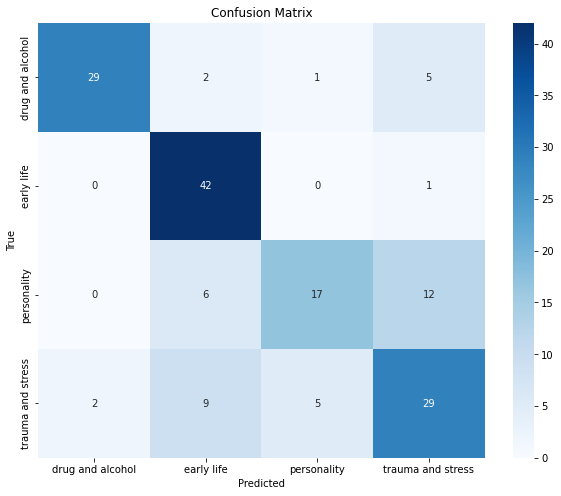

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Get predictions from the model
predictions = model.predict(val_dataset)
pred_labels = np.argmax(predictions.logits, axis=-1)

# True labels from the validation dataset
val_labels_array = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# Calculate accuracy
accuracy = accuracy_score(val_labels_array, pred_labels)

# Calculate precision
precision = precision_score(val_labels_array, pred_labels, average='weighted')

# Calculate recall
recall = recall_score(val_labels_array, pred_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(val_labels_array, pred_labels, average='weighted')

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


# Evaluate the model on the validation dataset to get the loss and accuracy
loss, accuracy = model.evaluate(val_dataset)

# Get predictions from the model
predictions = model.predict(val_dataset)
pred_labels = np.argmax(predictions.logits, axis=-1)

# True labels from the validation dataset
val_labels_array = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# Generate a classification report
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]
report = classification_report(val_labels_array, pred_labels, target_names=target_names)

# Print the evaluation metrics
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Plot the confusion matrix
cm = confusion_matrix(val_labels_array, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
